# Parameter estimation with BlackJAX


This tutorial explains how to estimate unknown parameters of initial value problems (IVPs) using Markov Chain Monte Carlo (MCMC) methods as provided by [BlackJAX](https://blackjax-devs.github.io/blackjax/).

## TL;DR
Compute log-objective of noisy observations of IVP solutions with ProbDiffEq. Sample from this objective using BlackJAX.
Evaluating the log-objective is described [in this paper](https://arxiv.org/abs/2202.01287) and the sampling is as done [in this paper](https://arxiv.org/abs/2002.09301).


## Technical setup
Let $f$ be a known vector field. In this example, we use the Lotka-Volterra model.
Consider an ordinary differential equation 

$$
\dot y(t) = f(y(t)), \quad 0 \leq t \leq T
$$

subject to an unknown initial condition $y(0) = \theta$.
Recall from the previous tutorials that the probabilistic IVP solution is an approximation of the posterior distribution

$$
p\left(y ~|~ [\dot y(t_n) = f(y(t_n))]_{n=0}^N, y(0) = \theta\right)
$$

for a Gaussian prior over $y$ and a pre-determined or adaptively selected grid $t_0, ..., t_N$.

We don't know the initial condition of the IVP, but assume that we have noisy observations of the IVP soution $y$ at the terminal time $T$ of the integration problem,

$$
p(\text{data}~|~ y(T)) = N(y(T), \sigma^2 I)
$$

for some $\sigma > 0$.
We can use these observations to reconstruct $\theta$, for example by sampling from $p(\text{data}~|~\theta)$ (which is a function of $\theta$).

Now, one way of evaluating $p(\text{data} ~|~ \theta)$ is to use any numerical solver, for example a Runge-Kutta method, to approximate $y(T)$ from $\theta$ and evaluate $N(y(T), \sigma^2 I)$.
But this ignores a few crucial concepts (e.g., the numerical error of the approximation; we refer to the references linked above). 
Instead, we can use a probabilistic solver instead of "any" numerical solver and build a more comprehensive model:

**We can combine probabilistic IVP solvers with MCMC methods to estimate $\theta$ from $\text{data}$ in a way that quantifies numerical approximation errors (and other model mismatches).**
To do so, we approximate the distribution of the IVP solution given the parameter $p(y(T) \mid \theta)$ and evaluate the marginal distribution of $N(y(T), \sigma^2I)$ given the probabilistic IVP solution.
More formally, we use ProbDiffEq to evaluate

\begin{align*}
M(\theta) 
:=&~p(\text{data} \mid \theta) \\
=&~\int p(\text{data} \mid y(T)) p(y(T) \mid [\dot y(t_n) = f(y(t_n))]_{n=0}^N, y(0) = \theta), \theta) d y(T).
\end{align*}

Loosely speaking, this distribution averages $N(y(T), \sigma^2I)$ over all IVP solutions $y(T)$ that are realistic given the differential equation, grid $t_0, ..., t_N$, and prior distribution $p(y)$.
This is useful, because if the approximation error is large, $M(\theta)$ "knows this". If the approximation error is ridiculously small, $M(\theta)$ "knows this" too and  we recover the procedure described for non-probabilistic solvers above.
**Interestingly, non-probabilistic solvers cannot do this** averaging because they do not yield a statistical description of estimated IVP solutions.
Non-probabilistic solvers would also fail if the observations were noise-free (i.e. $\sigma = 0$), but the present example notebook remains stable. (Try it yourself!)



To sample $\theta$ according to $M$ (respectively $\log M$), we evaluate $M(\theta)$ with ProbDiffEq, compute its gradient with JAX, and use this gradient to sample $\theta$ with BlackJAX:

1. ProbDiffEq: Compute the probabilistic IVP solution by approximating $p(y(T) ~|~ [\dot y(t_n) = f(y(t_n))]_n, y(0) = \theta)$

2. ProbDiffEq: Evaluate  $M(\theta)$ by marginalising over the IVP solution computed in step 1.

3. JAX: Compute the gradient $\nabla_\theta M(\theta)$

4. BlackJAX: Sample from $\log M(\theta)$ using, for example, the No-U-Turn-Sampler (which requires $\nabla_\theta M(\theta))$.

Here is how:

In [1]:
import functools

import blackjax
import jax
import jax.experimental.ode
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import solution_routines, solvers
from probdiffeq.doc_util import notebook
from probdiffeq.implementations import recipes
from probdiffeq.strategies import filters

In [2]:
# x64 precision
config.update("jax_enable_x64", True)

# CPU
config.update("jax_platform_name", "cpu")

# IVP examples in JAX
if not backend.has_been_selected:
    backend.select("jax")

# Nice-looking plots
plt.rcParams.update(notebook.plot_config())

## Problem setting

First, we set up an IVP and create some artificial data by simulating the system with "incorrect" initial conditions.

In [3]:
f, u0, (t0, t1), f_args = ivps.lotka_volterra()


@jax.jit
def vf(y, *, t, p=()):
    return f(y, *f_args)


theta_true = u0 + 0.5 * jnp.flip(u0)
theta_guess = u0  # initial guess

# Create a probabilistic solver
strategy = filters.Filter(
    recipes.IsoTS0.from_params(num_derivatives=2),
)
solver = solvers.CalibrationFreeSolver(strategy, output_scale_sqrtm=10.0)

In [4]:
def plot_solution(sol, *, ax, marker=".", **plotting_kwargs):
    for d in [0, 1]:
        ax.plot(sol.t, sol.u[:, d], marker="None", **plotting_kwargs)
        ax.plot(sol.t[0], sol.u[0, d], marker=marker, **plotting_kwargs)
        ax.plot(sol.t[-1], sol.u[-1, d], marker=marker, **plotting_kwargs)
    return ax


@jax.jit
def solve_adaptive(theta, *, save_at):
    return solution_routines.solve_and_save_at(
        vf, initial_values=(theta,), save_at=save_at, solver=solver
    )


save_at = jnp.linspace(t0, t1, num=250, endpoint=True)
solve_save_at = functools.partial(solve_adaptive, save_at=save_at)

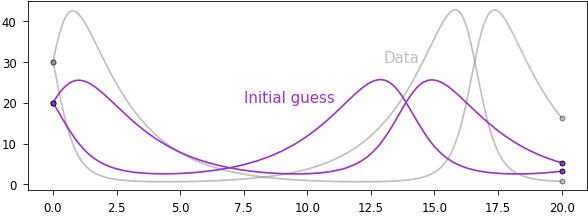

In [5]:
# Visualise the initial guess and the data

fig, ax = plt.subplots()

data_kwargs = {"alpha": 0.5, "color": "gray"}
ax.annotate("Data", (13.0, 30.0), **data_kwargs)
solution = solve_save_at(theta_true)
ax = plot_solution(solution, ax=ax, **data_kwargs)

sample_kwargs = {"color": "C4"}
ax.annotate("Initial guess", (7.5, 20.0), **sample_kwargs)
solution = solve_save_at(theta_guess)
ax = plot_solution(solution, ax=ax, **sample_kwargs)
plt.show()

## Objective functions via ProbDiffEq

Set up a log-objective function that we can plug into BlackJAX.

In [17]:
@jax.jit
def logobjective_fn(theta, *, data, ts, solver, obs_stdev=0.1):
    y_T = solve_fixed(theta, ts=ts, solver=solver)
    marginals, _ = y_T.posterior.condition_on_qoi_observation(
        data, observation_std=obs_stdev
    )
    return marginals.logpdf(data)


# Fixed steps for reverse-mode differentiability:


@jax.jit
def solve_fixed(theta, *, ts, solver):
    sol = solution_routines.solve_fixed_grid(
        vf, initial_values=(theta,), grid=ts, solver=solver
    )
    return sol[-1]


ts = jnp.linspace(t0, t1, endpoint=True, num=100)
data = solve_fixed(theta_true, ts=ts, solver=solver).u

log_M = functools.partial(logobjective_fn, data=data, ts=ts, solver=solver)

In [18]:
print(jnp.exp(log_M(theta_true)), ">=", jnp.exp(log_M(theta_guess)), "?")

0.1579898998495594 >= 0.0 ?


## Sampling with BlackJAX

From here on, BlackJAX takes over:

Set up a sampler.

In [19]:
@functools.partial(jax.jit, static_argnames=["kernel", "num_samples"])
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

Initialise the sampler, warm it up, and run the inference loop.

In [20]:
initial_position = theta_guess
rng_key = jax.random.PRNGKey(0)

In [21]:
# WARMUP
warmup = blackjax.window_adaptation(
    algorithm=blackjax.nuts, logprob_fn=log_M, num_steps=200, progress_bar=True
)
initial_state, nuts_kernel, _ = warmup.run(rng_key, initial_position)

Running window adaptation


In [22]:
# INFERENCE LOOP
rng_key, _ = jax.random.split(rng_key, 2)
states = inference_loop(
    rng_key, kernel=nuts_kernel, initial_state=initial_state, num_samples=200
)

## Visualisation

Now that we have samples of $\theta$, let's plot the corresponding solutions:

In [23]:
solution_samples = jax.vmap(solve_save_at)(states.position)

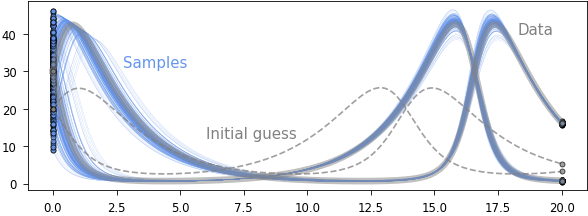

In [24]:
# Visualise the initial guess and the data

fig, ax = plt.subplots()

sample_kwargs = {"color": "C0"}
ax.annotate("Samples", (2.75, 31.0), **sample_kwargs)
for sol in solution_samples:
    ax = plot_solution(sol, ax=ax, linewidth=0.1, alpha=0.75, **sample_kwargs)

data_kwargs = {"color": "gray"}
ax.annotate("Data", (18.25, 40.0), **data_kwargs)
solution = solve_save_at(theta_true)
ax = plot_solution(solution, ax=ax, linewidth=4, alpha=0.5, **data_kwargs)

guess_kwargs = {"color": "gray"}
ax.annotate("Initial guess", (6.0, 12.0), **guess_kwargs)
solution = solve_save_at(theta_guess)
ax = plot_solution(solution, ax=ax, linestyle="dashed", alpha=0.75, **guess_kwargs)
plt.show()

The samples cover a perhaps surpringly large range of potential initial conditions, but lead to the "correct" data.

In parameter space, this is what it looks like:

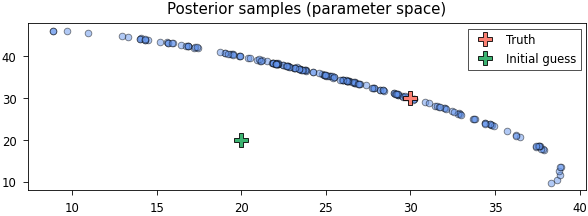

In [32]:
plt.title("Posterior samples (parameter space)")
plt.plot(states.position[:, 0], states.position[:, 1], "o", alpha=0.5, markersize=4)
plt.plot(theta_true[0], theta_true[1], "P", label="Truth", markersize=8)
plt.plot(theta_guess[0], theta_guess[1], "P", label="Initial guess", markersize=8)
plt.legend()
plt.show()

Let's add the value of $M$ to the plot to see whether the sampler covers the entire region of interest.

In [35]:
xlim = jnp.amin(states.position[:, 0]) - 0.5, jnp.amax(states.position[:, 0]) + 0.5
ylim = jnp.amin(states.position[:, 1]) - 0.5, jnp.amax(states.position[:, 1]) + 0.5

xs = jnp.linspace(*xlim, num=300)
ys = jnp.linspace(*ylim, num=300)
Xs, Ys = jnp.meshgrid(xs, ys)

Thetas = jnp.stack((Xs, Ys))
log_M_vmapped_x = jax.vmap(log_M, in_axes=-1, out_axes=-1)
log_M_vmapped = jax.vmap(log_M_vmapped_x, in_axes=-1, out_axes=-1)
Zs = log_M_vmapped(Thetas)  # expensive, because N^2 ODE solves

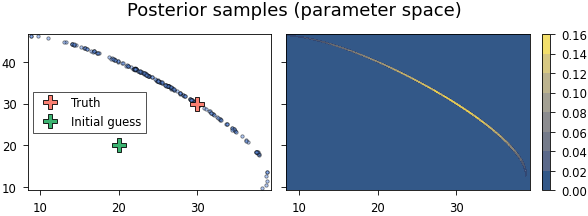

In [37]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)

ax_samples, ax_heatmap = ax

fig.suptitle("Posterior samples (parameter space)")
ax_samples.plot(
    states.position[:, 0], states.position[:, 1], ".", alpha=0.5, markersize=4
)
ax_samples.plot(theta_true[0], theta_true[1], "P", label="Truth", markersize=8)
ax_samples.plot(
    theta_guess[0], theta_guess[1], "P", label="Initial guess", markersize=8
)
ax_samples.legend()
im = ax_heatmap.contourf(Xs, Ys, jnp.exp(Zs), cmap="cividis", alpha=0.8)
plt.colorbar(im)
plt.show()

Looks great!

## Conclusion

In conclusion, a log-objective function can be provided by ProbDiffEq such that any of BlackJAX' samplers yield parameter estimates of IVPs. 


## What's next

Try to get a feeling for how the sampler reacts to changing observation noises, solver parameters, and so on.
We could extend the sampling problem from $\theta \mapsto \log M(\theta)$ to some $(\theta, \sigma) \mapsto \log \tilde M(\theta, \sigma)$, i.e., treat the observation noise as unknown and run Hamiltonian Monte Carlo in a higher-dimensional parameter space.
We could also add a prior distribution $p(\theta)$ to regularise the problem.


A final side note:
We could also replace the sampler with an optimisation algorithm and use this procedure to solve boundary value problems (albeit this may not be very efficient; use [this](https://arxiv.org/abs/2106.07761) algorithm instead).